In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [55]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
plt.rcParams.update({
    "text.usetex": True,
})

In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [8]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

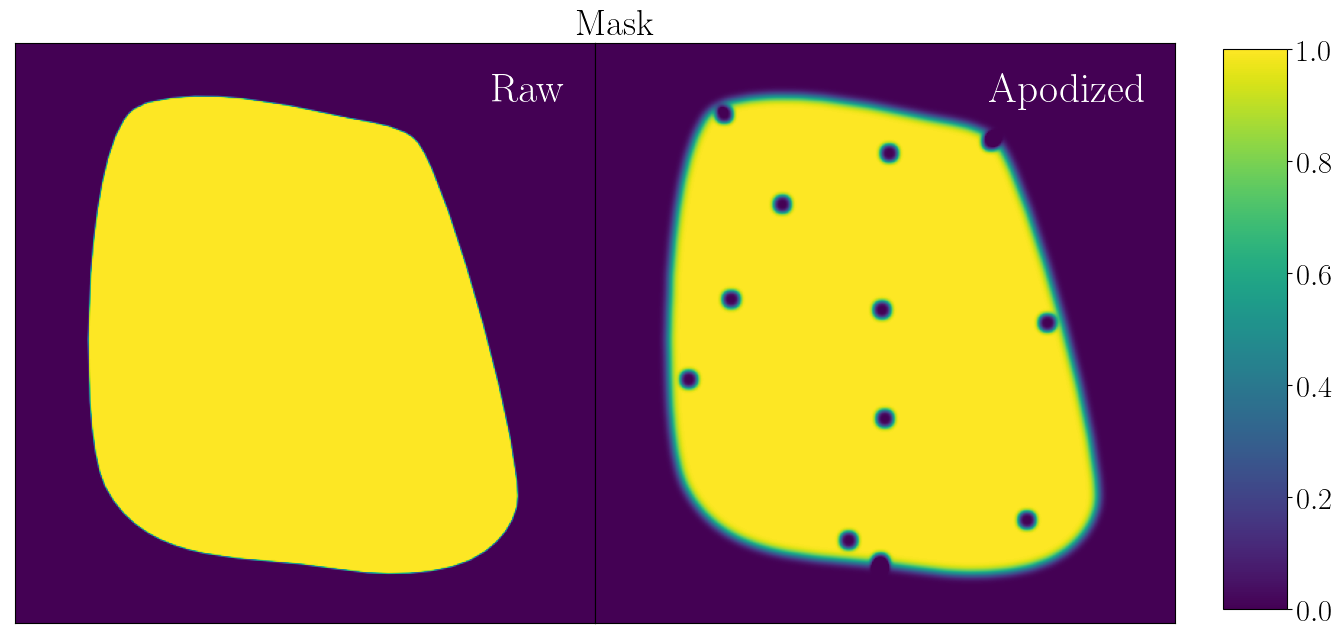

In [21]:
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig.subplots_adjust(wspace=0, hspace=0)


im0 = axs[0].imshow(mask, vmin=0, vmax=1)
im1 = axs[1].imshow(apodized_mask, vmin=0, vmax=1)


for ax,s in zip(axs, ['Raw', 'Apodized']):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(.95, .95,
        s=s,
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='top',
            c='white',
       fontsize=30)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax)
fig.suptitle('Mask', y=.9)

plt.savefig('figures/mask%dx%d.pdf'%(nX,nY), bbox_inches='tight')

In [45]:
apodized_mask_fourier = baseMap.fourier(apodized_mask)

/code/delon/LensQuEst/LensQuEst/flat_map.py:462: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


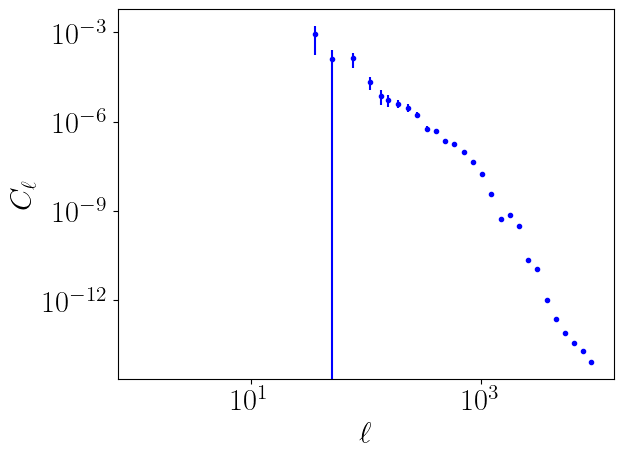

In [46]:
Cls= {}
Cls['apod'] = baseMap.powerSpectrum(apodized_mask_fourier,  plot=True, save=False)

Red
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.22478436e-04
 0.00000000e+00 1.24212388e-04 0.00000000e+00 1.37910723e-04
 0.00000000e+00 2.18897706e-05 7.52562409e-06 5.50125839e-06
 4.02811219e-06 2.93232729e-06 1.72157815e-06 5.86640151e-07
 4.72557039e-07 2.26828963e-07 1.73098188e-07 9.49377921e-08
 4.45002592e-08 1.71802654e-08 3.65042225e-09 5.40613069e-10
 7.07112734e-10 3.16569322e-10 2.20802709e-11 1.11851952e-11
 1.02304283e-12 2.22478450e-13 7.93669291e-14 3.44897307e-14
 1.99003162e-14 8.30877815e-15]


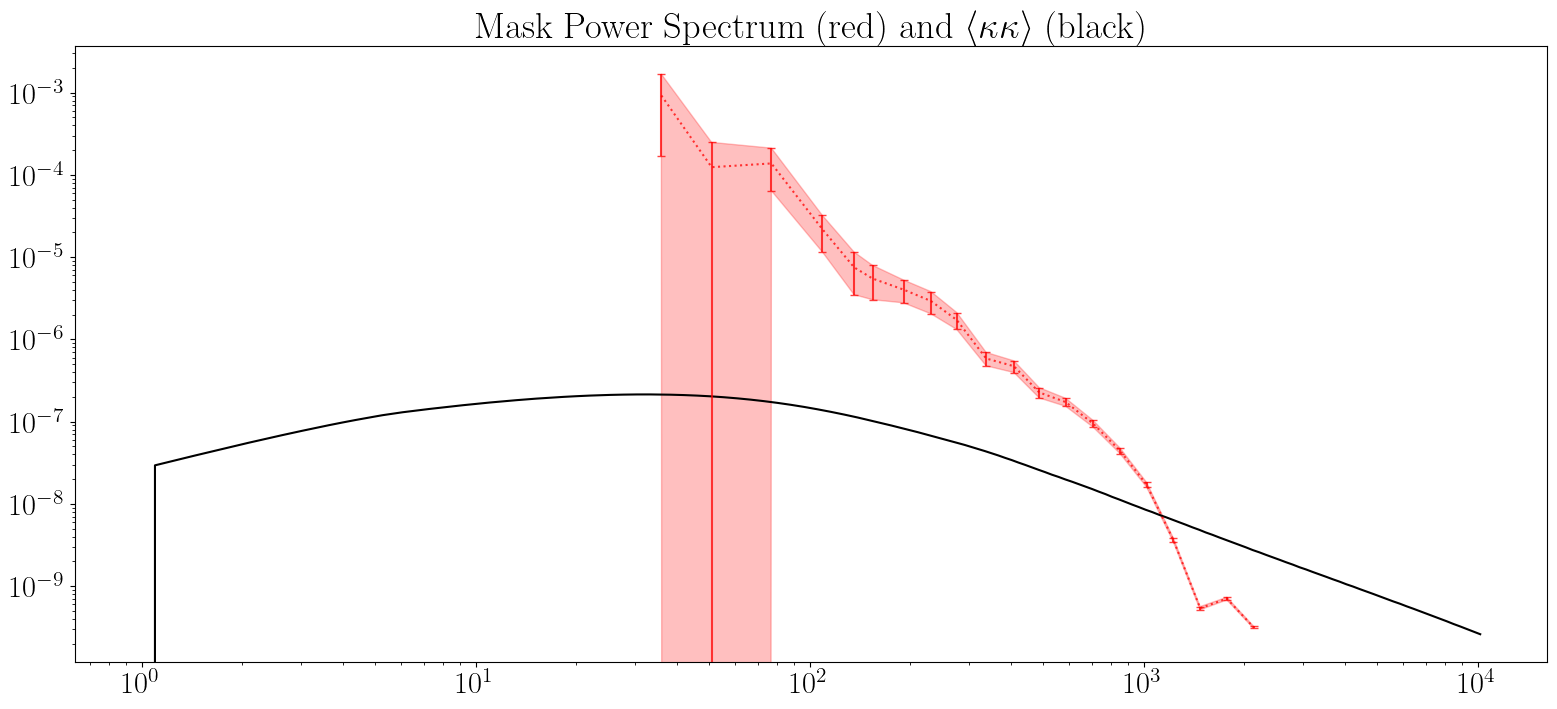

In [57]:
fig, axs = plt.subplots(ncols=1, figsize=(19,8))
axs = [axs]
col=dict(zip(Cls.keys(), ['Red','Blue']))
idxs=dict(zip(Cls.keys(), [0,1]))

ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, fNqCmb_fft]
theory_l=[r'$\big<\kappa\kappa\big>$']#, r'Projected noise $N$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, ClExpected, sty, label=l)


for key in Cls:
    print(col[key])
    ax = axs[idxs[key]]
    lCen, Cl, sCl = Cls[key]
    print(Cl)
    Ipos = np.where(Cl>=1e-10)
    Ineg = np.where(Cl<0.)

    ax.errorbar(lCen[Ipos], Cl[Ipos], yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, c=col[key], label=key)
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data, alpha=.25, color=col[key])
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.title(r'Mask Power Spectrum (red) and $\left<\kappa\kappa\right>$ (black)')
plt.savefig('figures/mask_ps.pdf')